In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import joblib
%matplotlib inline

In [3]:
# Load the dataset
df = pd.read_csv("Housing.csv")

# Display the first few rows
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [4]:
# Explore data shape, columns, and types
print("Shape:", df.shape)
print("Columns:", df.columns)
df.info()

Shape: (545, 13)
Columns: Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furni

In [5]:
# Summary statistics for numerical columns
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [6]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

Missing values:
 price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


In [7]:
# Remove outliers based on price (beyond 3 standard deviations)
price_mean = df['price'].mean()
price_std = df['price'].std()
df = df[(df['price'] >= price_mean - 3 * price_std) & (df['price'] <= price_mean + 3 * price_std)]
print("Shape after outlier removal:", df.shape)

Shape after outlier removal: (539, 13)


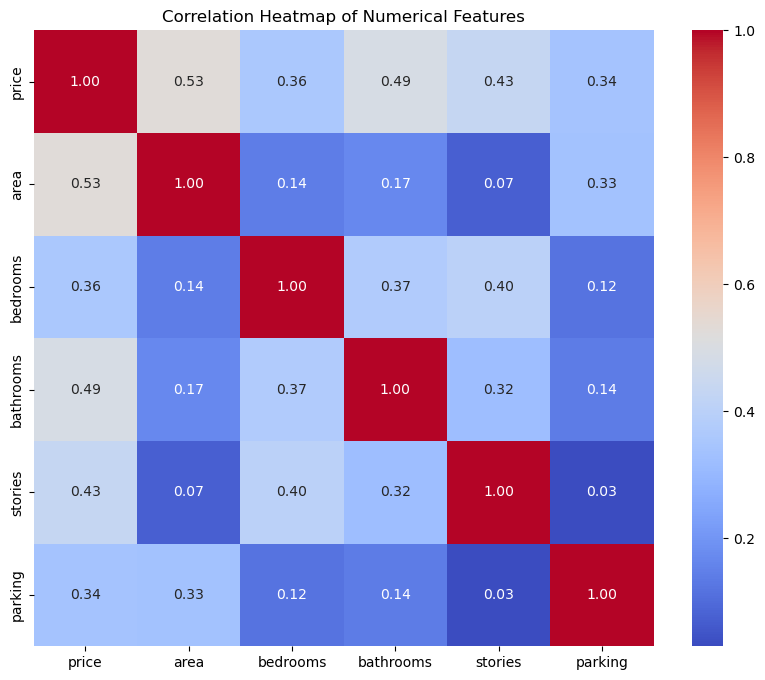

In [8]:
# Visualize correlations between numerical features
corr_matrix = df.select_dtypes(include=['int64', 'float64']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

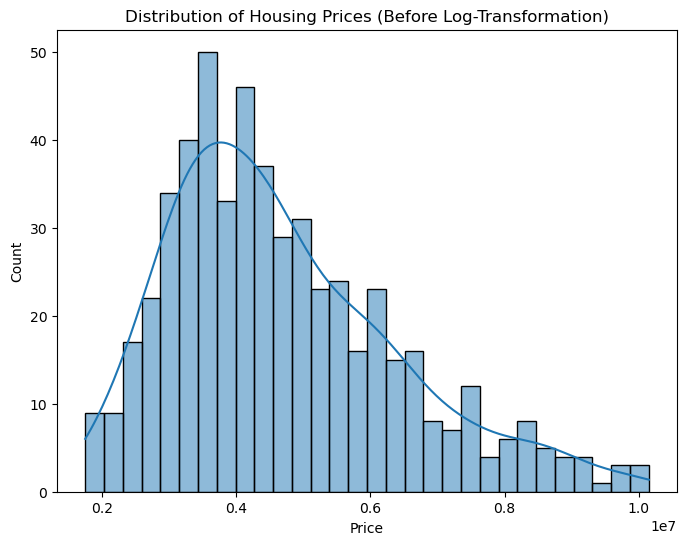

In [9]:
# Visualize distribution of target variable (price)
plt.figure(figsize=(8, 6))
sns.histplot(df['price'], kde=True, bins=30)
plt.title('Distribution of Housing Prices (Before Log-Transformation)')
plt.xlabel('Price')
plt.show()

In [10]:
# Preprocess categorical columns: Map 'yes'/'no' to 1/0
yes_no_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
for col in yes_no_columns:
    df[col] = df[col].str.strip().str.lower().map({'yes': 1, 'no': 0})

# One-hot encode 'furnishingstatus' (drop first to avoid multicollinearity)
df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=True)

# Log-transform the target variable to handle skewness
df['price'] = np.log(df['price'])

# Verify data types after preprocessing
print("Data types after preprocessing:\n", df.dtypes)

Data types after preprocessing:
 price                              float64
area                                 int64
bedrooms                             int64
bathrooms                            int64
stories                              int64
mainroad                             int64
guestroom                            int64
basement                             int64
hotwaterheating                      int64
airconditioning                      int64
parking                              int64
prefarea                             int64
furnishingstatus_semi-furnished       bool
furnishingstatus_unfurnished          bool
dtype: object


In [11]:
# Split features (X) and target (y)
X = df.drop('price', axis=1)
y = df['price']

# Scale numerical features for better model performance
numerical_cols = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Save the scaler for future use
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [12]:
# Split data into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (431, 13) Test shape: (108, 13)


In [13]:
# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
print("Linear Regression training complete!")

# Save the model
joblib.dump(lr_model, 'linear_model.pkl')

Linear Regression training complete!


['linear_model.pkl']

In [14]:
# Train RandomForest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
print("RandomForest training complete!")

# Save the model
joblib.dump(rf_model, 'random_forest_model.pkl')

RandomForest training complete!


['random_forest_model.pkl']